In [ ]:
pip install tqdm

In [1]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2023-02-26 10:36:40.216210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-26 10:36:40.216244: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


In [2]:
class RoadEnv(object):
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None

        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.compat.v1.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        width, height = image.size
        target_size = (2049,1025)
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

### Visualization
Now let's create some helper functions for decoding and visualizing the results.

In [3]:
def colour_label_method():
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def map_label_to_colours(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = colour_label_method()
    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def view_seg_image(image, seg_map):
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = map_label_to_colours(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

def view_output(SAMPLE_IMAGE):
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    view_seg_image(original_im, seg_map)

LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = map_label_to_colours(FULL_LABEL_MAP)

### Load the model from a frozen graph
There are two model checkpoints pre-trained on Cityscapes with different network backbones: MobileNetV2 and Xception65. We default to use MobileNetV2 for faster inference.

In [4]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
'mobilenetv2_coco_cityscapes_trainfine':
'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
'xception65_cityscapes_trainfine':
'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.compat.v1.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = RoadEnv(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


2023-02-26 10:37:14.670772: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/python/3.10.4/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-26 10:37:14.670813: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-26 10:37:14.670841: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-fa3eb7): /proc/driver/nvidia/version does not exist
2023-02-26 10:37:14.671358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Run on the sample image
The sample image is frame #0 in the MIT Driving Scene Segmentation (DriveSeg) Dataset.

running deeplab on the sample image...


2023-02-26 10:37:37.254140: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-26 10:37:38.284562: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25202700 exceeds 10% of free system memory.
2023-02-26 10:37:38.284678: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25202700 exceeds 10% of free system memory.
2023-02-26 10:37:38.330751: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25202700 exceeds 10% of free system memory.
2023-02-26 10:37:38.449018: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67305600 exceeds 10% of free system memory.
2023-02-26 10:37:38.929553: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67305600 exceeds 10% of free system memory.


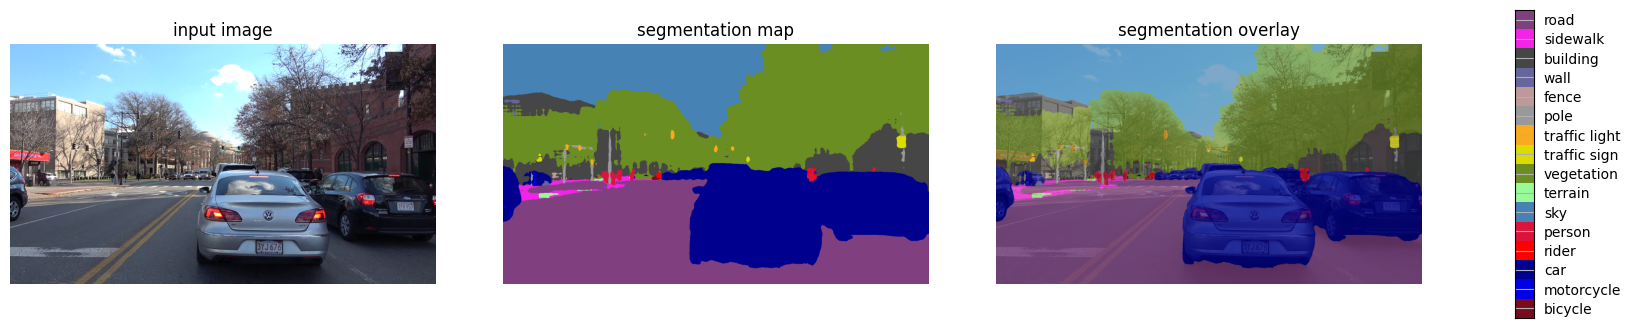

In [5]:
SAMPLE_IMAGE = r'/workspaces/python-projects/palan_project/projects/environment detection and segmentation/environment_detection_and_segmentation.png'
print('running deeplab on the sample image...')

view_output(SAMPLE_IMAGE)

running deeplab on the sample image...


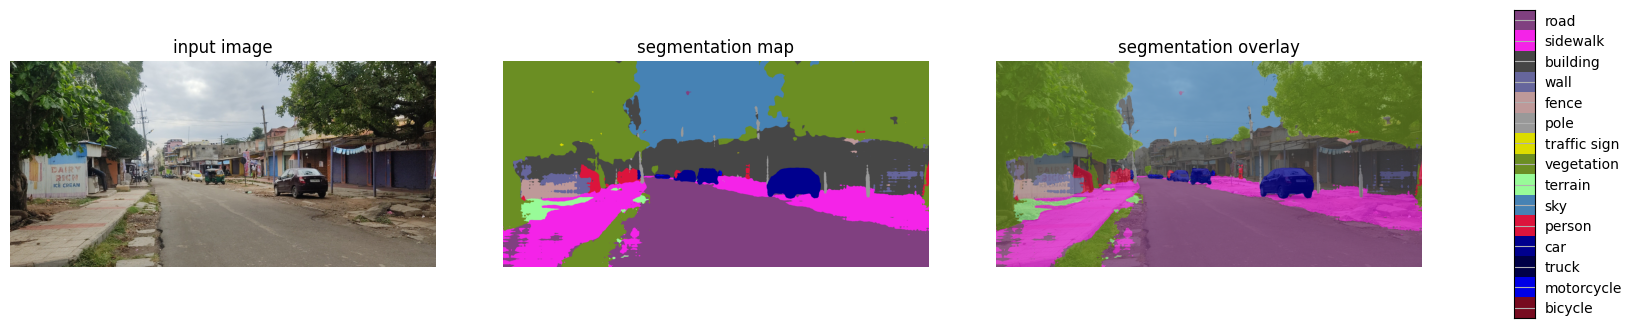

In [11]:
SAMPLE_IMAGE = r'/workspaces/python-projects/palan_project/projects/environment detection and segmentation/test_local.jpg'
print('running deeplab on the sample image...')

view_output(SAMPLE_IMAGE)

In [10]:
segment = MODEL.run(Image.open(SAMPLE_IMAGE))
segment.dtype

dtype('int32')

In [12]:
segment

array([[8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

### Run on the sample video
The sample video is frame #0 to #597 in the MIT DriveSeg Dataset.

In [ ]:
def vis_segmentation_stream(image, seg_map, index):
    plt.figure(figsize=(12, 7))

    seg_image = map_label_to_colours(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.grid('off')
    plt.title('segmentation overlay | frame #%d'%index)
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


def run_visualization_video(frame, index):
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)


SAMPLE_VIDEO = r'/workspaces/python-projects/palan_project/projects/environment detection and segmentation/mit_driveseg_sample.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
num_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

In [6]:
def vis_segmentation_stream(image, seg_map, index):
    # Create a new figure
    plt.figure(figsize=(12, 7))

    # Apply the segmentation color map to the segmentation map
    seg_image = map_label_to_colours(seg_map).astype(np.uint8)

    # Display the original image and the segmentation overlay
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)

    # Remove the axis and grid lines
    plt.axis('off')
    plt.grid('off')

    # Save the plot to a JPEG image buffer
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    plt.close()
    print('segmentation overlay | frame #%d'%index)
    return f.getvalue()


def run_visualization_video(frame, index):
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)

# Path to input video file
input_file = r'/workspaces/python-projects/palan_project/projects/environment detection and segmentation/mit_driveseg_sample.mp4'
# Path to output video file
output_file = "output_video.mp4"

# Open the input video file
cap = cv.VideoCapture(input_file)

# Get the video dimensions and frame rate
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv.CAP_PROP_FPS))

fourcc = cv.VideoWriter_fourcc(*"mp4v")
out = cv.VideoWriter(output_file, fourcc, fps, (width, height))

try:
    # Loop through each frame in the video
    for i in range(fps):
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            break

        # Process the frame using the DeepLab model
        original_im = Image.fromarray(frame[..., ::-1])
        seg_map = MODEL.run(original_im)
        vis_segmentation_stream(original_im, seg_map, i)

        # Get the current plot as a JPEG image
        f = BytesIO()
        plt.savefig(f, format='jpeg')
        img = np.frombuffer(f.getvalue(), dtype=np.uint8)
        plt.close()

        # Convert the JPEG image back to an RGB image
        img = cv.imdecode(img, cv.IMREAD_COLOR)
        # Write the processed frame to the output video file
        out.write(img)

    # Release the video reader and writer objects
    cap.release()
    out.release()

    print("Video processing complete.")

except KeyboardInterrupt:
    # Release the video reader and writer objects and close the plot
    cap.release()
    out.release()
    plt.close()
    print("Video processing interrupted.")

segmentation overlay | frame #0
segmentation overlay | frame #1
segmentation overlay | frame #2
segmentation overlay | frame #3
segmentation overlay | frame #4
segmentation overlay | frame #5
segmentation overlay | frame #6
segmentation overlay | frame #7
segmentation overlay | frame #8
segmentation overlay | frame #9
segmentation overlay | frame #10
segmentation overlay | frame #11
segmentation overlay | frame #12
segmentation overlay | frame #13
segmentation overlay | frame #14
segmentation overlay | frame #15
segmentation overlay | frame #16
segmentation overlay | frame #17
segmentation overlay | frame #18
segmentation overlay | frame #19
segmentation overlay | frame #20
segmentation overlay | frame #21
segmentation overlay | frame #22
segmentation overlay | frame #23
segmentation overlay | frame #24


### Evaluation
Now let's evaluate the model performance with the ground truth annotation. First read the annotation from a tar file.

In [ ]:
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()
    
    def fetch(self, index):
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt

SAMPLE_GT = r'C:\Users\sakth\PycharmProjects\python-projects\palan_project\projects\environment detection and segmentation\environment_detection_and_segmentation_gt.tar.gz'

dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
gt = dataset.fetch(0)  # sample image is frame 0
view_seg_image(original_im, gt)

### Evaluate on the sample image
There are many ways to measure the performance of a segmentation model. The most straight forward one is pixel accuracy, which calculates how many pixels are correctly predicted. Another commonly used one is the standard Jaccard Index (intersection-over-union) as IoU = TP ⁄ (TP+FP+FN), where TP, FP, and FN are the numbers of true positive, false positive, and false negative pixels, respectively.

In [ ]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""    
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


print('evaluating on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
seg_map = MODEL.run(original_im)
gt = dataset.fetch(0)  # sample image is frame 0
acc, intersection, union = evaluate_single(seg_map, gt)
class_iou = np.round(intersection / union, 5)
print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))